In [1]:
import pandas as pd
import numpy as np

In [2]:
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding

In [3]:
docs = ['Well done',
        'Good work',
        'Great effort',
        'nice work',
        'Excellent!',
        'Weak',
        'Poor effort!',
        'not good',
        'poor work',
        'Could have done better.'
       ]
labels = np.array([1,1,1,1,1,0,0,0,0,0])

Now, let's integer encode each doc so that the embedding layer will have seqs of ints. 
An alternative is to use BoW or TF-IDF

The function one_hot creates a hash of each word as an efficient int encoding. 
If chosen a vocab size large enough then prob of collisions is reduced

In [4]:
vocab_size = 50
encoded_docs = [one_hot(d, vocab_size) for d in docs]
print(encoded_docs)

[[41, 19], [35, 45], [31, 31], [1, 45], [35], [37], [29, 31], [39, 35], [29, 45], [27, 36, 19, 11]]


Seqs have diff lens and Keras needs inputs to be vectorized and all inputs have same len.

Solution: pad all input seqs to have len = 4.

We can do this w the pad_sequences func in Keras

In [5]:
max_length = 4
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)

[[41 19  0  0]
 [35 45  0  0]
 [31 31  0  0]
 [ 1 45  0  0]
 [35  0  0  0]
 [37  0  0  0]
 [29 31  0  0]
 [39 35  0  0]
 [29 45  0  0]
 [27 36 19 11]]


The embedding has a vocab of 50 and input len of 4. We choose a small embedding space of 8 dims.

The output of the embedding layer will be 4 vectors of 8 dims each. (word->int_encoding->8dim_vec)

In [6]:
model = Sequential()
model.add(Embedding(vocab_size, 8, input_length=max_length))

We flatten this to a one 32-dimensional vector to pass on to the dense output layer

In [7]:
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [8]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 4, 8)              400       
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
model.fit(padded_docs, labels, epochs=50, verbose=0)
loss, accuracy = model.evaluate(padded_docs, labels, verbose=0)
print('Acc:', accuracy*100)

Acc: 80.0000011920929


# Let's give it a try with Amazon reviews!

In [10]:
data = pd.read_csv('datasets/musical_instruments_reviews/Musical_instruments_reviews.csv')

In [11]:
data.dropna(inplace=True, axis=0)

In [12]:
mvcols = (data.isnull().sum())
print(mvcols[mvcols > 0])

Series([], dtype: int64)


In [13]:
def sentiment(rating):
    if(rating > 3):
        return 1
    else:
        return 0

In [14]:
data['review'] = data['reviewText'] + ' ' + data['summary']

In [15]:
data['sentiment'] = data['overall'].apply(sentiment)

In [16]:
data.drop(['reviewerID','asin','reviewerName','helpful','reviewText',
           'overall','summary','unixReviewTime','reviewTime'],
          inplace=True,
          axis=1
         )

In [17]:
data.head()

,review,sentiment
0,"Not much to write about here, but it does exac...",1
1,The product does exactly as it should and is q...,1
2,The primary job of this device is to block the...,1
3,Nice windscreen protects my MXL mic and preven...,1
4,This pop filter is great. It looks and perform...,1


In [18]:
data['sentiment'].value_counts()

1    8991
0    1236
Name: sentiment, dtype: int64

In [19]:
import spacy
nlp = spacy.load('en')

In [20]:
def nlp_pipeline(text):
    processed_text = ''
    doc = nlp(text)
    for token in doc:
        if token.is_stop == False and token.pos_ != 'PUNCT':
            processed_text += token.lemma_ + ' '
    return processed_text

In [21]:
data['review_token'] = data['review'].apply(nlp_pipeline)

In [22]:
data.head()

,review,sentiment,review_token
0,"Not much to write about here, but it does exac...",1,write exactly suppose filter pop sound recordi...
1,The product does exactly as it should and is q...,1,product exactly affordable realize double scre...
2,The primary job of this device is to block the...,1,primary job device block breath produce poppin...
3,Nice windscreen protects my MXL mic and preven...,1,nice windscreen protect MXL mic prevent pop th...
4,This pop filter is great. It looks and perform...,1,pop filter great look perform like studio filt...


## Let's apply embeddings!

In [23]:
vocab_size = 1000

In [24]:
def review_length(text):
    return len(text)

In [25]:
data['review_len'] = data['review_token'].apply(review_length)

In [26]:
data['review_len'].describe()

count    10227.000000
mean       273.070109
std        337.497830
min         10.000000
25%        102.000000
50%        166.000000
75%        302.000000
max       6627.000000
Name: review_len, dtype: float64

In [27]:
data[data['review_len'] == 6627]

,review,sentiment,review_token,review_len
6576,"COMPARISONS: I have compared, side by side, th...",1,comparison compare follow pedal fulltone mini ...,6627


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

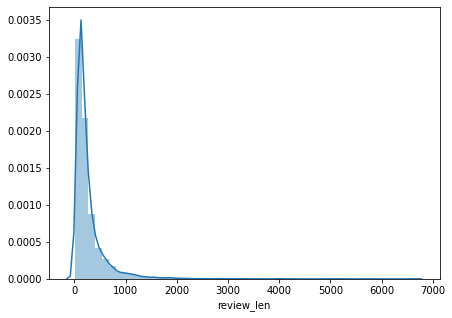

In [30]:
plt.figure(figsize=(7, 5))
sns.distplot(data['review_len'])
plt.show()

In [31]:
def text_prepro(text):
    proc_text = one_hot(text, vocab_size)
    return proc_text

In [32]:
docs = data['review_token'].values.tolist()

In [33]:
encoded_docs = [one_hot(doc, vocab_size) for doc in docs]

In [34]:
maxdocsize = -1
for doc in encoded_docs:
    if len(doc) > maxdocsize:
        maxdocsize = len(doc)

In [35]:
maxdocsize

1011

In [36]:
maxlength = 1011

In [37]:
padded_docs = pad_sequences(encoded_docs, maxlen=maxlength, padding='post')

##### Applying SMOTE

In [38]:
from imblearn.combine import SMOTETomek

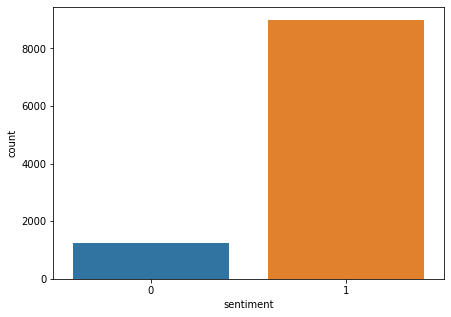

In [39]:
plt.figure(figsize=(7, 5))
sns.countplot(data['sentiment'])
plt.show()

In [40]:
smk = SMOTETomek(random_state=0, sampling_strategy=0.8)

In [41]:
X, y = smk.fit_sample(padded_docs, data['sentiment'])

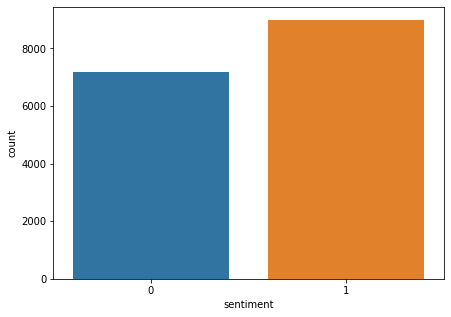

In [42]:
plt.figure(figsize=(7, 5))
sns.countplot(y)
plt.show()

In [49]:
def build_model(vec_size):
    model = Sequential()
    model.add(Embedding(vocab_size, vec_size, input_length=maxlength))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [45]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

In [46]:
kFold = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

In [52]:
accs = []
f1s = []
vec_size = 16

for i, (train_idx, test_idx) in enumerate(kFold.split(X, y)):
    print('Fold:', i)
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    model = build_model(vec_size)
    model.fit(
        X_train, y_train,
        epochs=50,
        verbose=0
    )
    probs = model.predict(X_test)
    preds = (probs > 0.5)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    accs.append(acc)
    f1s.append(f1)
    print('Acc:', acc, 'F1:', f1)
    print()
print('Avg acc:', np.mean(accs))
print('Avg F1:', np.mean(f1s))

Fold: 0
Acc: 0.8674289245982695 F1: 0.8827548510522001

Fold: 1
Acc: 0.8862793572311496 F1: 0.8989010989010988

Fold: 2
Acc: 0.8843894899536322 F1: 0.8961687951138257

Fold: 3
Acc: 0.8918083462132921 F1: 0.9031007751937984

Fold: 4
Acc: 0.8797527047913447 F1: 0.8929848693259974

Avg acc: 0.8819317645575374
Avg F1: 0.8947820779173841


In [ ]:
# 8-dim vecs
# Avg acc: 0.8728442387896596
# Avg F1: 0.8862925884390837

# 16-dim vecs
# Avg acc: 0.8816836860436015
# Avg F1: 0.8946440451539612

# 32-dim vecs
# Avg acc: 0.8851456852297283
# Avg F1: 0.897950227612356

### How to deploy the model?

In [76]:
#text = 'wrong improvement old formulation noticeable'
#text = 'this is the best piece of equipment i have owned'
#text = 'what a piece of junk!'
#text = 'simply great!'
text = 'everybody should get one of these!'
processed_text = nlp_pipeline(text)
print(processed_text)

everybody 


In [77]:
onehot_text = one_hot(processed_text, vocab_size)
print(onehot_text)

[152]


In [78]:
padded_text = pad_sequences([onehot_text], maxlen=maxlength, padding='post')
print(padded_text)

[[152   0   0 ...   0   0   0]]


In [79]:
probs = model.predict(padded_text)
if probs < 0.5:
    pred = 'neg'
else:
    pred = 'pos'
print(pred)

neg
